## Task 0: import data

1. Create folder called data next to main.ipynb
1. Create file called .gitignore next to main.ipynb. In this write: data/
1. Download data between 01-01-2021 and 01-01-2022
    1. Nordpool - hourly prices in DKK
    1. Bornholm network manager - kirkeby Sose Vindpark Active Power
    1. Digital Energy Lab/Weather Observations/DMI - All streams from Bornholm
1. Place data files under /data and rename to production, prices, and weather

## TO-DO
1. Fix optimization model
1. Clean data for prolonged periods of lacking data
1. Determine final features. Probably cant use AR model
1. Implement validation for hyperparameter tuning. K-fold?
1. Implement task 7
1. Implement model 2
    1. Run optimizer on training set, feed to regressor insted of production
    1. Try classification and regression

## Task 1: Optimization model

In [39]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB

# Create optimization model for bidding strategy in DA and balancing market
# Fixed price and production arrays

lambda_DA = [65.3, 72.1, 80.5, 67.8, 55.9, 64.2, 78.4, 71.3, 85.1, 90.5, 63.4, 70.9, 
             68.1, 75.6, 83.3, 69.4, 61.2, 66.7, 76.5, 82.2, 59.8, 72.4, 88.0, 73.9]  # Day-ahead market prices (EUR/MWh)

lambda_up = [9.4, 11.3, 130.5, 10.9, 90.8, 108.2, 115.9, 103.4, 128.5, 132.2, 104.1, 
             109.6, 120.7, 112.3, 138.4, 121.9, 109.3, 118.7, 126.8, 137.5, 102.5, 
             116.9, 141.6, 115.4]  # Upward regulation prices (EUR/MWh)

lambda_down = [25.4, 32.6, 45.2, 30.1, 23.9, 27.8, 33.7, 31.4, 40.5, 38.1, 27.2, 35.4, 
               29.3, 31.9, 44.1, 36.7, 26.4, 34.7, 41.5, 39.9, 28.5, 37.6, 43.7, 33.1]  # Downward regulation prices (EUR/MWh)

P_proj = [82.3, 77.4, 92.1, 84.6, 65.2, 70.1, 88.3, 79.5, 90.9, 95.4, 69.8, 83.2, 
          76.9, 81.7, 89.2, 85.0, 67.5, 73.8, 91.1, 94.5, 62.3, 78.9, 93.4, 81.5]  # Realized production (MW)

def market_bid(lambda_DA, lambda_up, lambda_down, P_proj,  C = 6500):
    
    t = len(P_proj)
    #### Create model ####
    model = gp.Model()

    #### Decision variables ####
    # Production/bid in DA market
    P_bid = model.addVars(t, lb = 0, ub = C, vtype=GRB.CONTINUOUS, name="P_bid")

    # Binary variables for upward and downward regulation
    u = model.addVars(t, vtype=GRB.BINARY, name="upward_regulation")  # Binary for upward regulation
    d = model.addVars(t, vtype=GRB.BINARY, name="downward_regulation")  # Binary for downward regulation

    #### Set Constraints ####
    # Ensure that in each hour, the wind farm cannot be paid for both upward and downward regulation
    #model.addConstrs((u[i] + d[i] <= 1 for i in range(t)), "up_or_down") # Not binding

    # Ensure that the wind farm is either in upward or downward regulation. 
    model.addConstrs((u[i] + d[i] == 1 for i in range(t)), "regulation")

    # Only allow upward or downward regulation to be non-zero when the respective binary is active.  
    model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
    model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")


    #### Set Objective ####
    model.setObjective(
        gp.quicksum(lambda_DA[i] * P_bid[i] for i in range(t)) + 
        gp.quicksum(lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] - lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] for i in range(t)),
        GRB.MAXIMIZE
    )

    #### Optimize ####
    model.setParam('OutputFlag', 0)
    model.optimize()


    #### Print results ####
    bid = model.getAttr("X", P_bid)
    bid = np.array([bid[i] for i in range(t)])
    return bid


P_bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)
print(P_bid)


[6500.  6500.    92.1 6500.    65.2   70.1   88.3   79.5   90.9   95.4
   69.8   83.2   76.9   81.7   89.2   85.    67.5   73.8   91.1   94.5
   62.3   78.9   93.4   81.5]


## Task 2: Data collection

Want to determine some features that we believe will be useful predictors of future wind power. Could be previous wind power, features of the weather, season or similar. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import StandardScaler

# Import and format relevant data 
# Import production data
production = pd.read_csv('data/production.csv')
production['ts'] = pd.to_datetime(production['ts']) # Convert to datetime
production = production.set_index('ts') # Set datetime as index
production = production.resample('h').mean() # Resample to hourly data
production = production.rename(columns={"kirkeby Sose Vindpark Active Power | aki_sov_effekt | 804128": "power"}) # Rename column
production = production.fillna(0) # Fill missing values with 0
production = -1 * production # Change sign to positive for production

# Import weather data
weather = pd.read_csv('data/weather.csv')
weather['ts'] = pd.to_datetime(weather['ts'])
weather = weather.set_index('ts')
weather = weather.resample('h').mean()
weather = weather.fillna(0)

# Import electricity prices
prices = pd.read_csv('data/prices.csv',  decimal=',')
prices['ts'] = pd.to_datetime(prices['ts'])
prices = prices.set_index('ts')
prices = prices.rename(columns = {
    "Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820": "spotprice"})

# Merge data
data = pd.merge(production, weather, left_index=True, right_index=True)

# Rename columns for easier access
data = data.rename(columns = {
    "Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576": "humidity_Hammer_Odde",
    "Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592" : "temp_max_Hammer_Odde",
    "Observed accumulated precipitation the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/precip_past1h/06197 | 406528": "precipitation_Nex",
    "Observed mean wind speed the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_speed_past1h/06197 | 406512": "windspeed_Nex",
    "Observed maximum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_max_past1h/06197 | 406464": "temp_max_Nex",
    "Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672": "global_radiation_Hammer_Odde",
    "Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608": "temp_min_Hammer_Odde",
    "Observed minimum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_min_past1h/06197 | 406480": "temp_min_Nex",
    "Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560": "temp_mean_Hammer_Odde",
    "Observed mean temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_mean_past1h/06197 | 406432": "temp_mean_Nex",
    "Observed mean humidity past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/humidity_past1h/06197 | 406448": "humidity_Nex",
    "Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640": "windspeed_Hammer_Odde",
    "Observed mean wind direction the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_dir_past1h/06197 | 406496": "winddirection_Nex",
    "Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656": "precipitation_Hammer_Odde",
    "Observed mean intensity of global radiation in the latest hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/radia_glob_past1h/06197 | 406544": "global_radiation_Nex",
    "Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624": "winddirection_Hammer_Odde"
})


                      lambda_up  lambda_down
ts                                          
2021-01-01 00:00:00  358.570007   358.570007
2021-01-01 01:00:00  332.450012   332.450012
2021-01-01 02:00:00  319.350006   319.350006
2021-01-01 03:00:00  300.529999   300.529999
2021-01-01 04:00:00  299.119995   299.119995


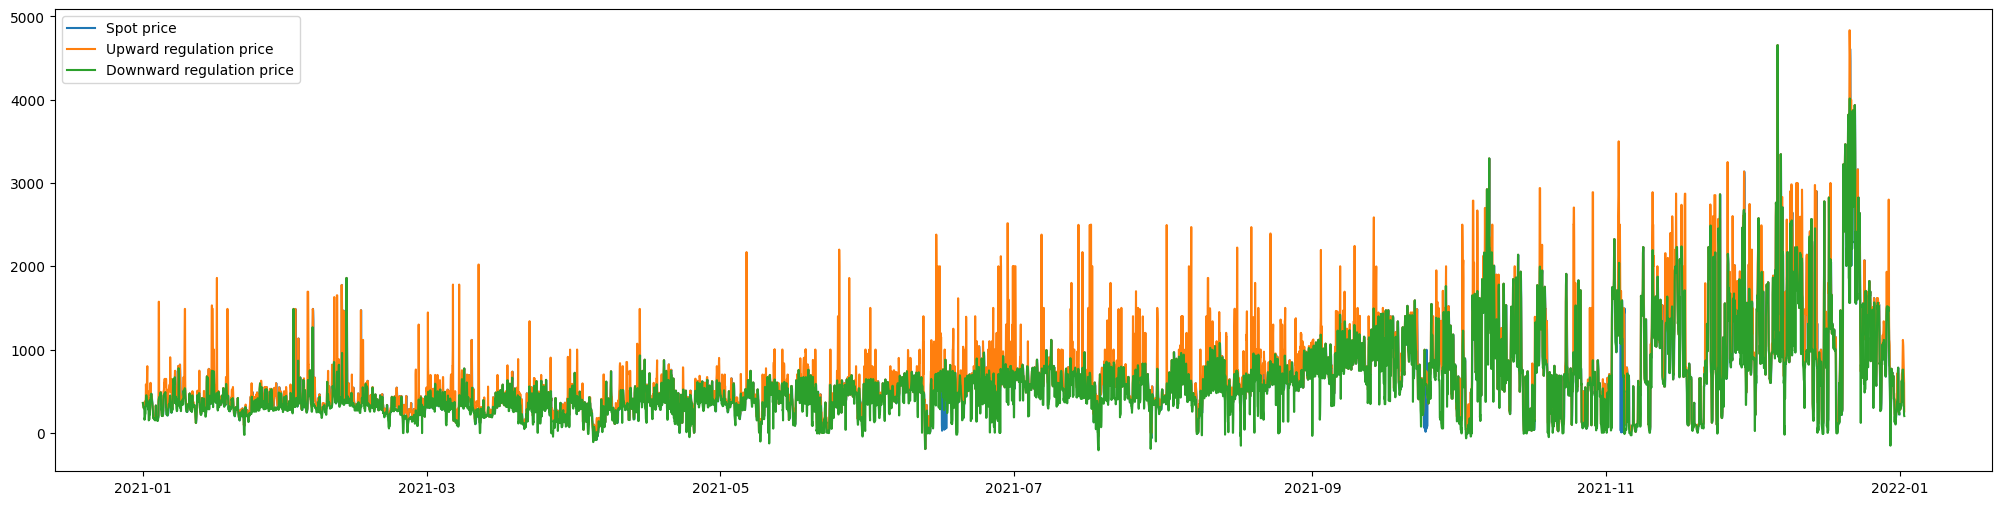

In [56]:
balance = pd.read_csv('./data/balance.csv', decimal=',')
balance = balance[balance["PriceArea | PriceArea | 804696"] == "DK2"]
balance['ts'] = pd.to_datetime(balance['ts'])
balance = balance.set_index('ts')
balance.drop(columns = ["PriceArea | PriceArea | 804696"], inplace = True)
balance.rename(columns = {"BalancingPowerPriceUpDKK | BalancingPowerPriceUpDKK | 804719": "lambda_up",
                           "BalancingPowerPriceDownDKK | BalancingPowerPriceDownDKK | 804721" : "lambda_down"}, 
                           inplace = True)

print(balance.head())

# Plot spotprice and balance prices
plt.figure(figsize=(25,6))
plt.plot(prices['spotprice'], label='Spot price')
plt.plot(balance['lambda_up'], label='Upward regulation price')
plt.plot(balance['lambda_down'], label='Downward regulation price')
plt.legend()
plt.show()


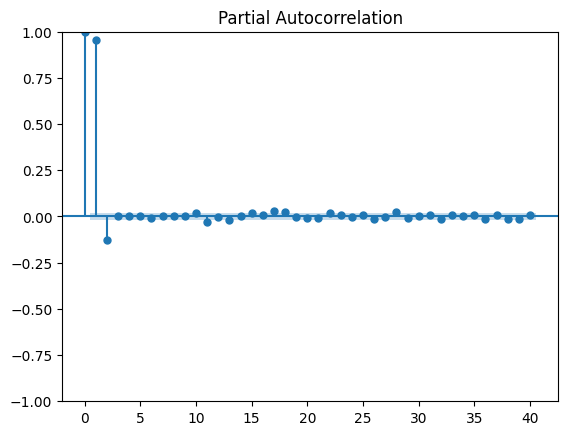

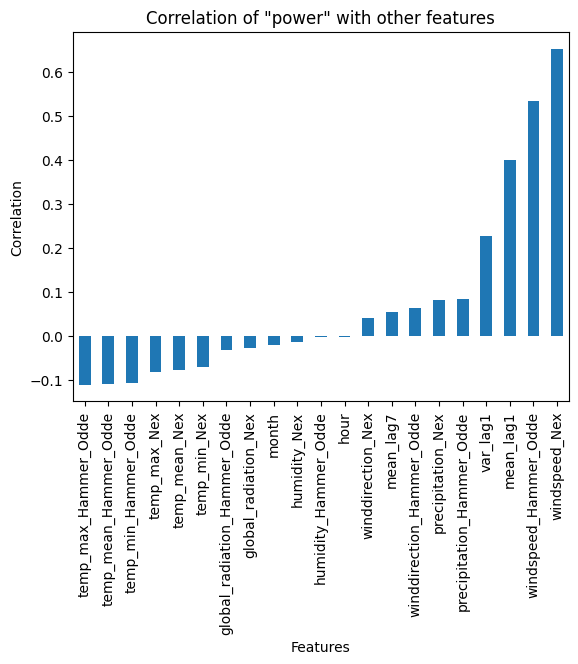

In [6]:
# Check autocorrelation of power production
tsaplots.plot_pacf(production)
plt.show()


### Add more potential features ###
# Add lagged power production as features. Are we allowed to use this?
#data['power_lag1'] = data['power'].shift(1)
#data['power_lag2'] = data['power'].shift(2)

# Add hour, day and month as features. Might test later with one-hot encoding
data['hour'] = data.index.hour
data['month'] = data.index.month

# Add mean power production the day before as feature
daily_mean_power = data['power'].resample('D').mean()
mean_lag1 = daily_mean_power.shift(1)
data['mean_lag1'] = data.index.normalize().map(mean_lag1)

# Add variance of power production the day before as feature
daily_var_power = data['power'].resample('D').var()
var_lag1 = daily_var_power.shift(1)
data['var_lag1'] = data.index.normalize().map(var_lag1)

# Add mean power production the week before as feature
weekly_mean_power = data['power'].resample('W').mean()
mean_lag7 = weekly_mean_power.shift(1)
data['mean_lag7'] = data.index.normalize().map(mean_lag7)

# Interpolate missing values
data = data.interpolate()

# Check correlation between features
data.corr().iloc[1:, 0].sort_values().plot(kind='bar')
plt.title('Correlation of "power" with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

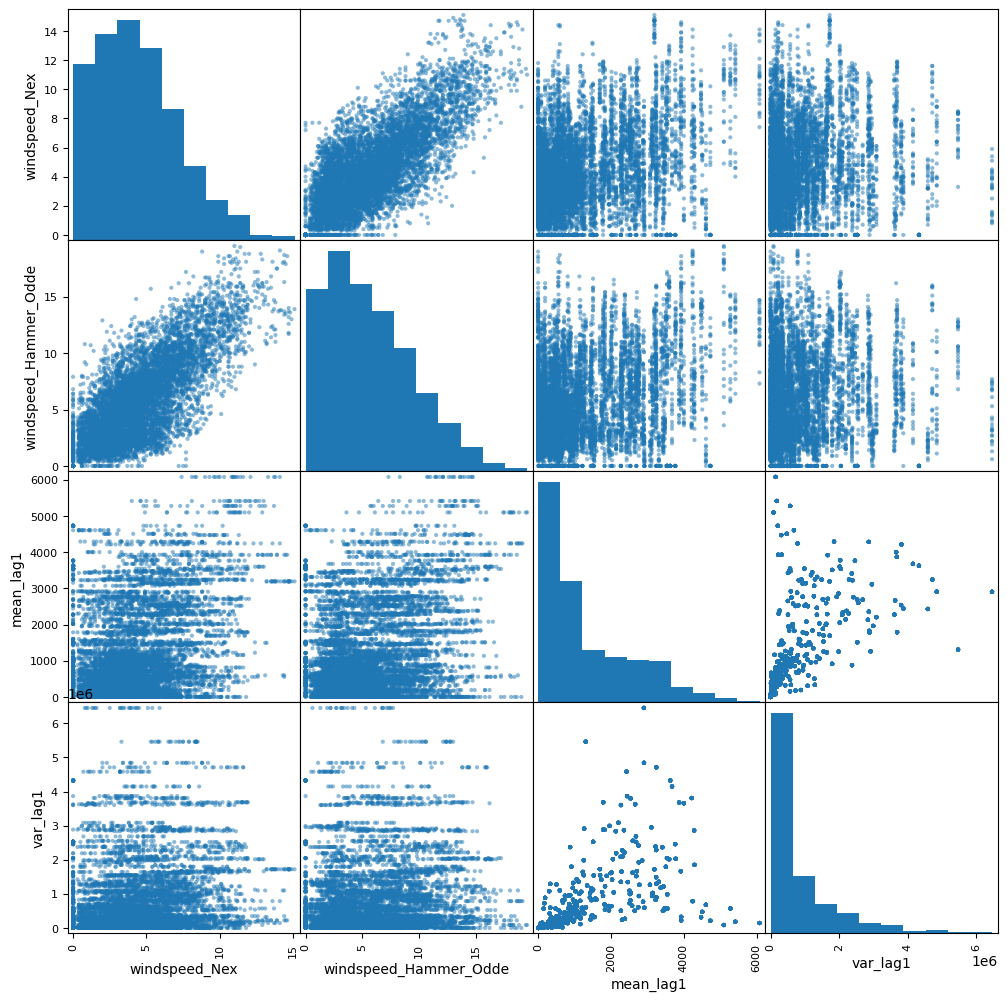

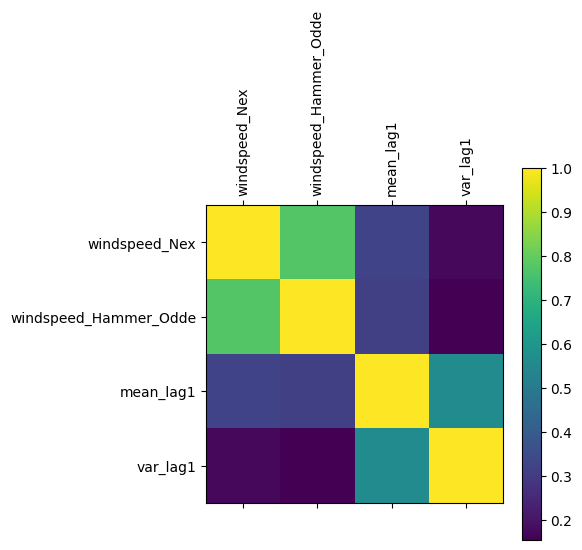

In [7]:
# Look closer at features with high correlation
# Show scatter plots matrix of features with correlation > 0.2
features = data.columns[1:]
corr = data.corr().iloc[1:, 0]
corr = corr[abs(corr) > 0.2]
features = corr.index
pd.plotting.scatter_matrix(data[features], figsize=(12, 12))
plt.show()

plt.matshow(data[features].corr())
plt.xticks(range(len(corr)), corr.index, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.show()


In [8]:

# Select features with correlation > 0.2
x = data[features].dropna()
y = data['power'][x.index]

# Remove first 8 hours to avoid missing values
x = x.iloc[8:]
y = y.iloc[8:]

# Print selected features
print(x.columns)

# Scale data 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Add bias term to input data
X = np.concatenate([np.ones((x.shape[0], 1)), x_scaled], axis=1)

# Split data into training and test set for time series data
split_fraction = 0.8
split_index = int(len(x) * split_fraction)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Index(['windspeed_Nex', 'windspeed_Hammer_Odde', 'mean_lag1', 'var_lag1'], dtype='object')


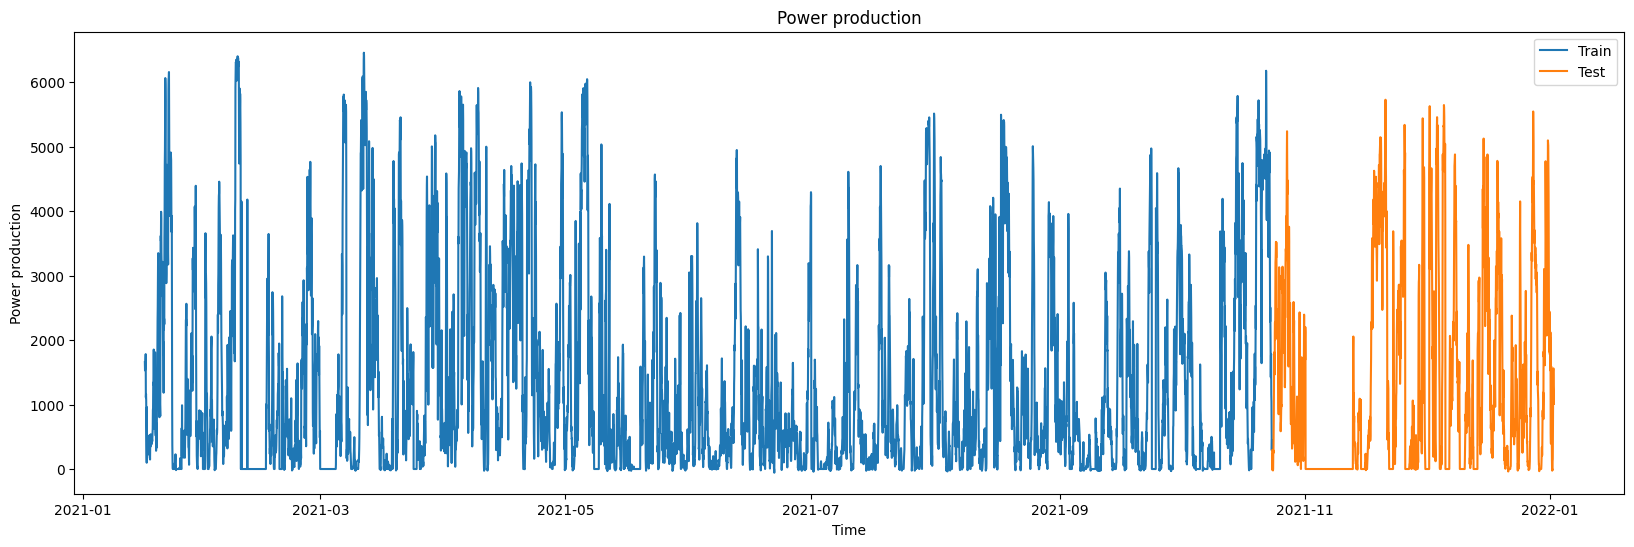

In [9]:
# Plot target variable against time, split into training and test set
plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

## Task 3: Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression


# Implement gradient descent

def gradient_descent(X_train, max_iterations=10000, alpha = 0.01):
    # Initial guess of coefficients
    theta = np.zeros(X_train.shape[1])

    # Number of observations
    m = len(X_train)
    
    for _ in range(max_iterations):

        # Linear regression prediction
        h = theta @ X_train.T

        # The partial derivatives of the cost function
        dt = (1/m) * ((h - y_train.T) @ X_train)

        # Update the coefficients
        theta = theta - alpha * dt

        # Break if the change in coefficients is small
        if np.linalg.norm(alpha * dt) < 1e-6:
            return theta
        
    return theta


# Implement closed form solution
theta_cfs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Compare the two solutions
print(gradient_descent(X_train))
print(theta_cfs)




[1345.6550955   840.58792214   85.63279067  290.8782885    39.35282259]
[1345.65508821  840.58825185   85.63244361  290.87829701   39.35281288]


RMSE: 1189.475453861165
MAE: 913.6004669457926
R2: 0.4096664808211924


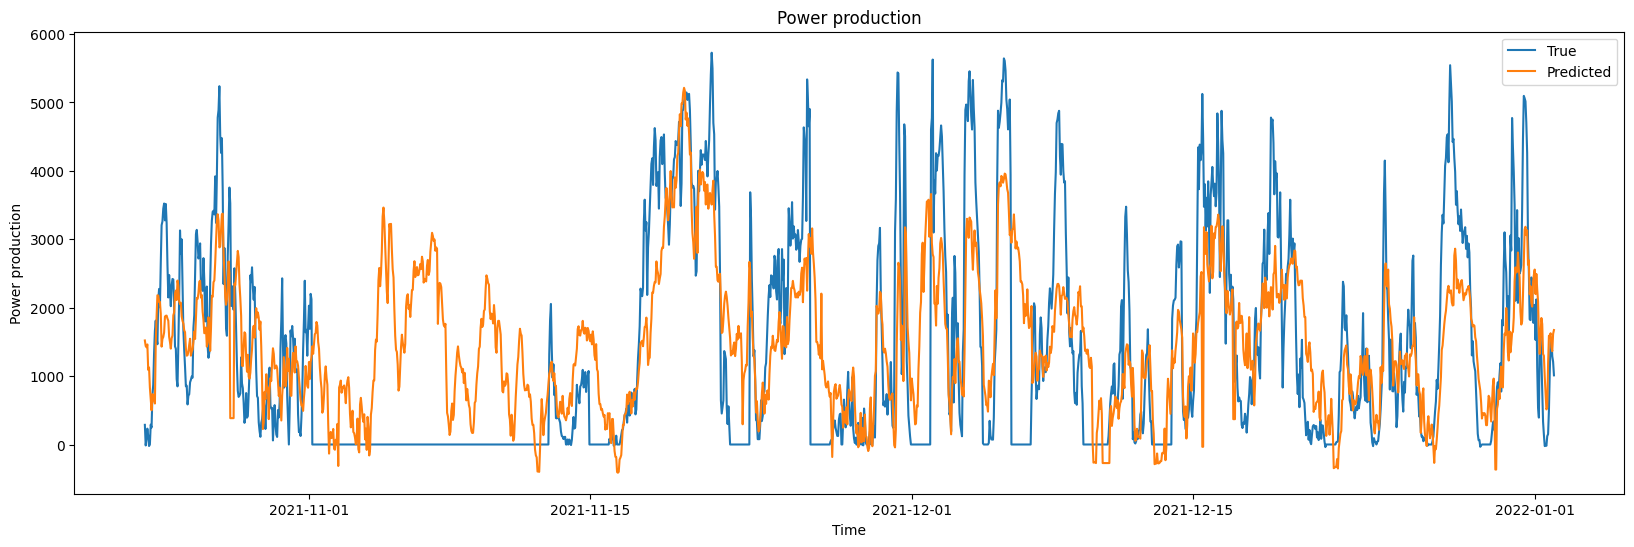

In [11]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions
y_OLS = X_test @ theta_cfs

# Calculate metrics
rmse = np.sqrt(np.mean((y_test - y_OLS)**2))
mae = mean_absolute_error(y_test, y_OLS)
r2 = r2_score(y_test, y_OLS)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_OLS, label='Predicted')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

## Task 4: Non-linear regression

[1033.26562126  698.23549322   82.78440928  185.79283185   71.74601687
  303.78046078]
RMSE: 1235.0000889266016
MAE: 930.0083855150217
R2: 0.363614241266091


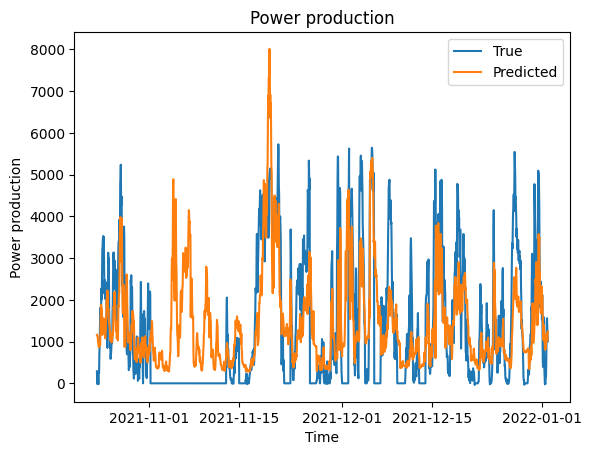

In [12]:
# 4.1: Implement polynomial regression
# Add wind speed as a second degree polynomial
x_train_poly = np.concatenate([X_train, np.power(X_train[:, 1:2] ,2)], axis=1)
x_test_poly = np.concatenate([X_test, np.power(X_test[:, 1:2], 2)], axis=1)

theta_poly = np.linalg.inv(x_train_poly.T @ x_train_poly) @ x_train_poly.T @ y_train

y_poly = x_test_poly @ theta_poly
print(theta_poly)

# Calculate metrics
rmse_poly = np.sqrt(np.mean((y_test - y_poly)**2))
mae_poly = mean_absolute_error(y_test, y_poly)
r2_poly = r2_score(y_test, y_poly)

print(f"RMSE: {rmse_poly}")
print(f"MAE: {mae_poly}")
print(f"R2: {r2_poly}")


plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_poly, label='Predicted')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()


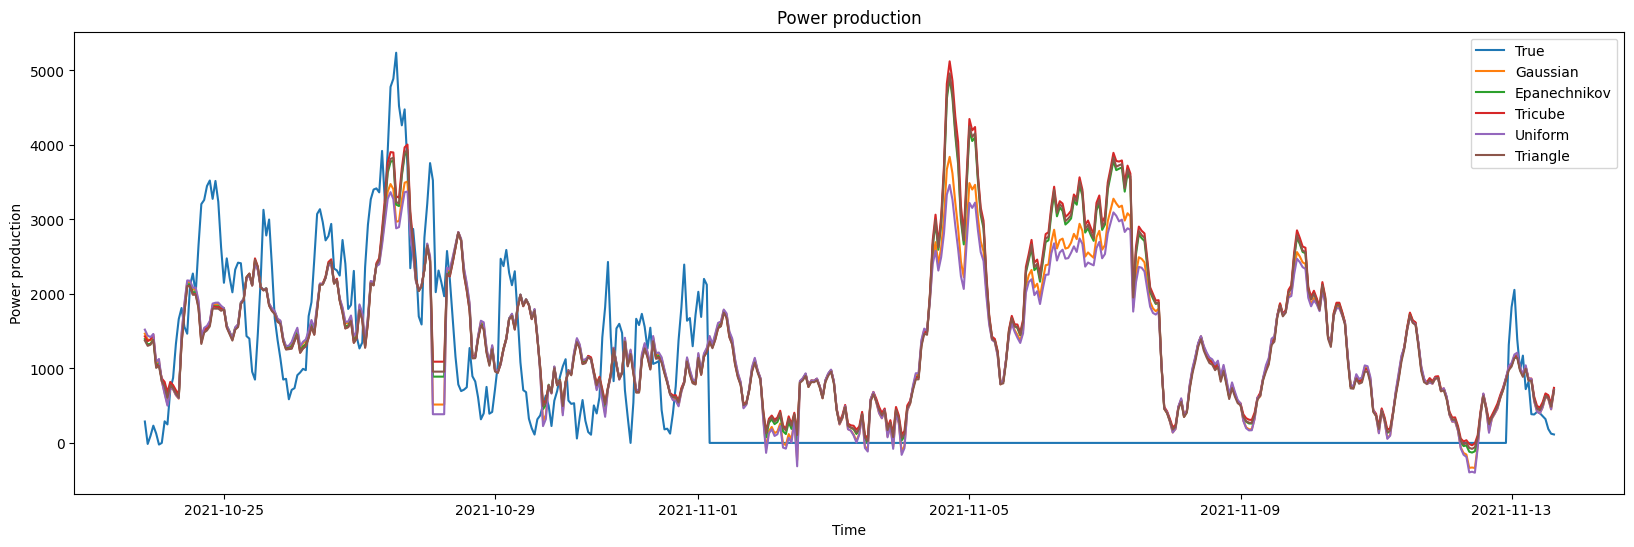

In [13]:
# 4.2: Implement weighted least squares
# Possible kernels
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return kern

def tricube(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return kern

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return kern


# Implement locally weighted least squares
def lwls(X_train, y_train, X_test, kernel=gaussian, bandwidth=0.1):
    y_pred = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        # Calculate weights
        weights = kernel(np.linalg.norm(X_train - x, axis=1) / bandwidth)
        W = np.diag(weights)
        
        # Calculate theta
        theta = np.linalg.inv(X_train.T @ W @ X_train) @ X_train.T @ W @ y_train
        
        # Make prediction
        y_pred[i] = x @ theta
        
    return y_pred

# Make predictions
n = 500
band = 5
y_lwls_gauss = lwls(X_train, y_train, X_test[:n], kernel=gaussian, bandwidth=band)
y_lwls_epan = lwls(X_train, y_train, X_test[:n], kernel=epanechnikov, bandwidth=band)
y_lwls_tricube = lwls(X_train, y_train, X_test[:n], kernel=tricube, bandwidth=band)
y_lwls_uniform = lwls(X_train, y_train, X_test[:n], kernel=uniform, bandwidth=band)
y_lwls_triangle = lwls(X_train, y_train, X_test[:n], kernel=triangle, bandwidth=band)

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test.index[:n], y_test[:n], label='True')
plt.plot(y_test.index[:n], y_lwls_gauss, label='Gaussian')
plt.plot(y_test.index[:n], y_lwls_epan, label='Epanechnikov')
plt.plot(y_test.index[:n], y_lwls_tricube, label='Tricube')
plt.plot(y_test.index[:n], y_lwls_uniform, label='Uniform')
plt.plot(y_test.index[:n], y_lwls_triangle, label='Triangle')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

## Task 5: Regularization

RMSE Lasso: 1188.9226317323903
MAE Lasso: 914.9658429613661
[  0.         837.44245494  79.96685108 287.52611597  32.78116498]
RMSE Ridge: 1234.8890941457323
MAE Ridge: 996.1133347460565
[  0.         425.40706676 249.68444981 205.91354955  79.06581937]


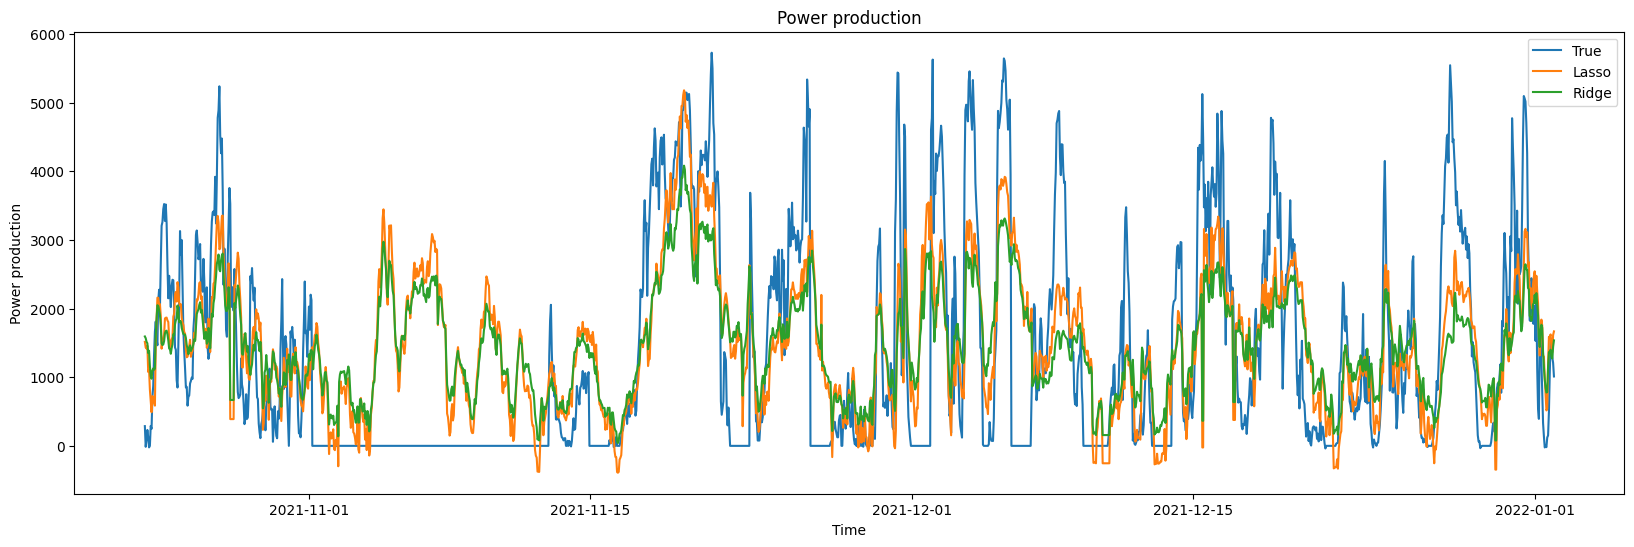

In [17]:
from sklearn.linear_model import Lasso, Ridge

# Implement Lasso regression
lasso = Lasso(alpha=10)
lasso.fit(X_train, y_train)
y_lasso = lasso.predict(X_test)

# Implement Ridge regression
ridge = Ridge(alpha=5000)
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(X_test)

# Evaluate models
rmse_lasso = np.sqrt(np.mean((y_test - y_lasso)**2))
mae_lasso = mean_absolute_error(y_test, y_lasso)

rmse_ridge = np.sqrt(np.mean((y_test - y_ridge)**2))
mae_ridge = mean_absolute_error(y_test, y_ridge)

print(f"RMSE Lasso: {rmse_lasso}")
print(f"MAE Lasso: {mae_lasso}")
print(lasso.coef_)

print(f"RMSE Ridge: {rmse_ridge}")
print(f"MAE Ridge: {mae_ridge}")
print(ridge.coef_)

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_lasso, label='Lasso')
plt.plot(y_test.index, y_ridge, label='Ridge')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()


In [25]:
# Temporarily set values for poly and lwls
y_poly = np.ones(len(y_test))
y_lwls_gauss = np.ones(len(y_test))

# Create dataframe with test data and predictions
model_names = ['OLS', 'poly', 'y_lwls_gauss', 'Lasso', 'Ridge']
projections = pd.DataFrame({'OLS': y_OLS, 'poly': y_poly, 'y_lwls_gauss': y_lwls_gauss, 'Lasso': y_lasso, 'Ridge': y_ridge}, index=y_test.index)

test_data = pd.concat([y_test, prices, projections], axis=1, join='inner')

# Add mock data for lambda_up and lambda_down
test_data['lambda_down'] = 0.9 * test_data['spotprice']# np.random.permutation(test_data['spotprice'].values)
test_data['lambda_up'] = 1.1 * test_data['spotprice'] #np.random.permutation(test_data['spotprice'].values)


test_data

,power,spotprice,OLS,poly,y_lwls_gauss,Lasso,Ridge,lambda_down,lambda_up
ts,,,,,,,,,
2021-10-23 20:00:00,287.349983,1562.44,1520.842406,1.0,1.0,1515.119151,1593.636934,1406.196,1718.684
2021-10-23 21:00:00,-13.653103,1284.18,1439.212983,1.0,1.0,1433.378007,1568.431958,1155.762,1412.598
2021-10-23 22:00:00,95.571832,1120.87,1421.389086,1.0,1.0,1416.733370,1516.461586,1008.783,1232.957
2021-10-23 23:00:00,231.600774,791.63,1462.440779,1.0,1.0,1458.743989,1494.287124,712.467,870.793
2021-10-24 00:00:00,127.073792,763.88,1090.727086,1.0,1.0,1076.385575,1351.951827,687.492,840.268
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,1818.334499,357.01,2311.257255,1.0,1.0,2301.768159,1876.557380,321.309,392.711
2021-12-31 20:00:00,2441.932761,252.53,2073.052946,1.0,1.0,2062.786465,1820.431343,227.277,277.783
2021-12-31 21:00:00,2379.814753,245.99,2015.931380,1.0,1.0,2003.931697,1866.685628,221.391,270.589


## Task 6: Revenue calculation for evaluation

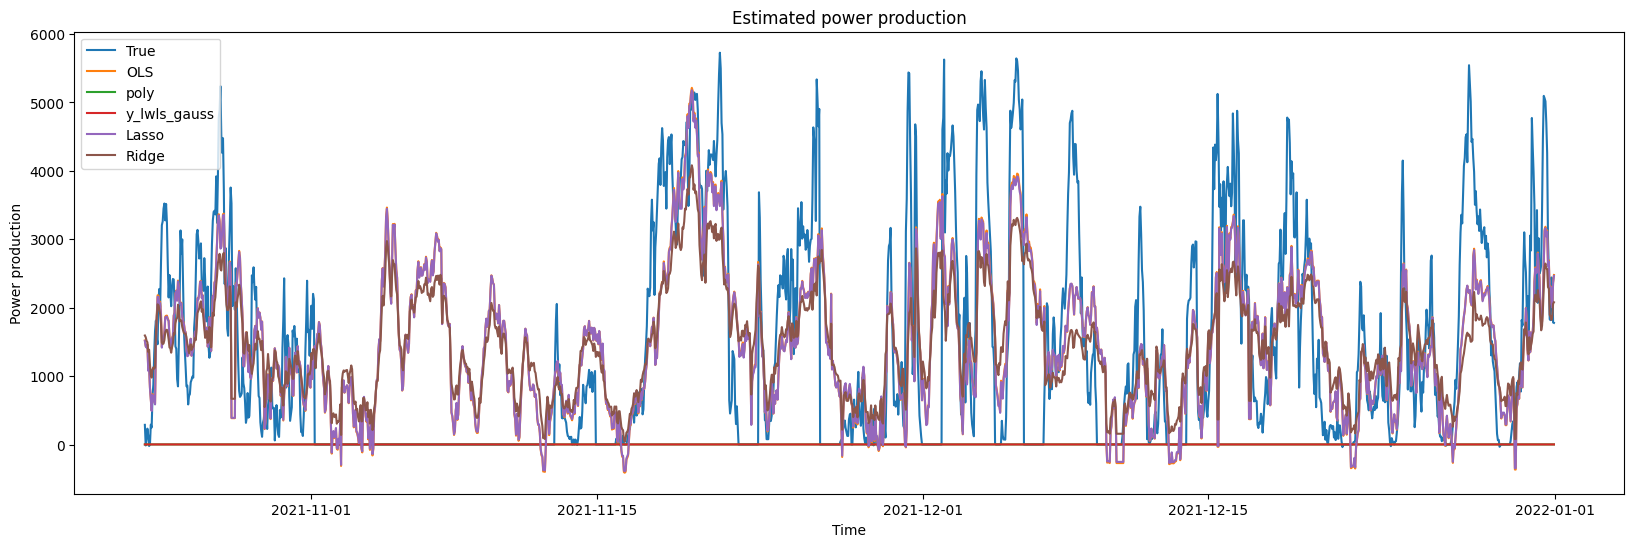

In [26]:
# Plot all predictions together with test data
plt.figure(figsize=(20, 6))
plt.plot(test_data.index, test_data['power'], label='True')
plt.plot(test_data.index, test_data['OLS'], label='OLS')
plt.plot(test_data.index, test_data['poly'], label='poly')
plt.plot(test_data.index, test_data['y_lwls_gauss'], label='y_lwls_gauss')
plt.plot(test_data.index, test_data['Lasso'], label='Lasso')
plt.plot(test_data.index, test_data['Ridge'], label='Ridge')
plt.legend()
plt.title('Estimated power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

In [33]:
def revenue(real, P_proj, lambda_DA, lambda_up, lambda_down):
    bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)
    rev = np.sum(bid * lambda_DA + lambda_down * np.maximum(real - bid, 0) - lambda_up * np.maximum(bid - real, 0))
    return rev, bid



revenues = pd.DataFrame(index = [1], columns=model_names)
bids = pd.DataFrame(index = np.arange(1659), columns=model_names)


for model in model_names:
    #for date in revenues.index:
    #    daily_data = test_data.loc[test_data.index == date]
    #    revenues[date] = revenue(daily_data["spotprice"], daily_data[model], daily_data["lambda_up"], daily_data["lambda_down"])
    revenues[model], bids[model] = revenue(test_data["power"].values, test_data[model].values, test_data["spotprice"].values, test_data["lambda_up"].values, test_data["lambda_down"].values)


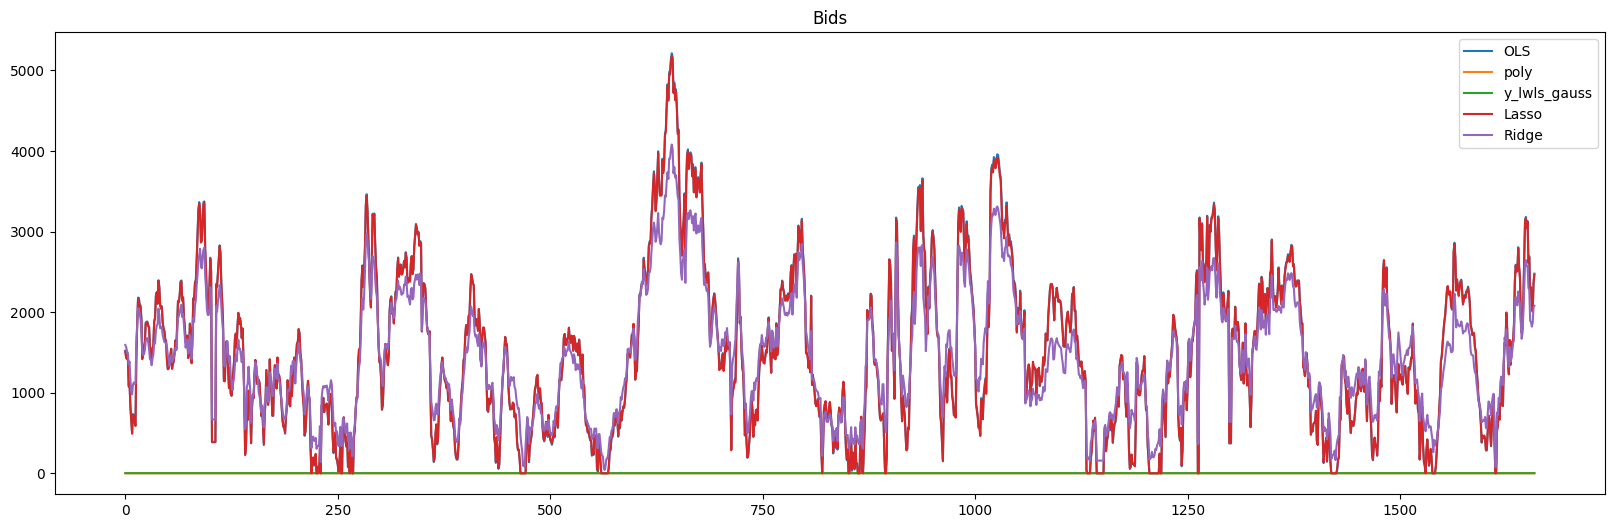

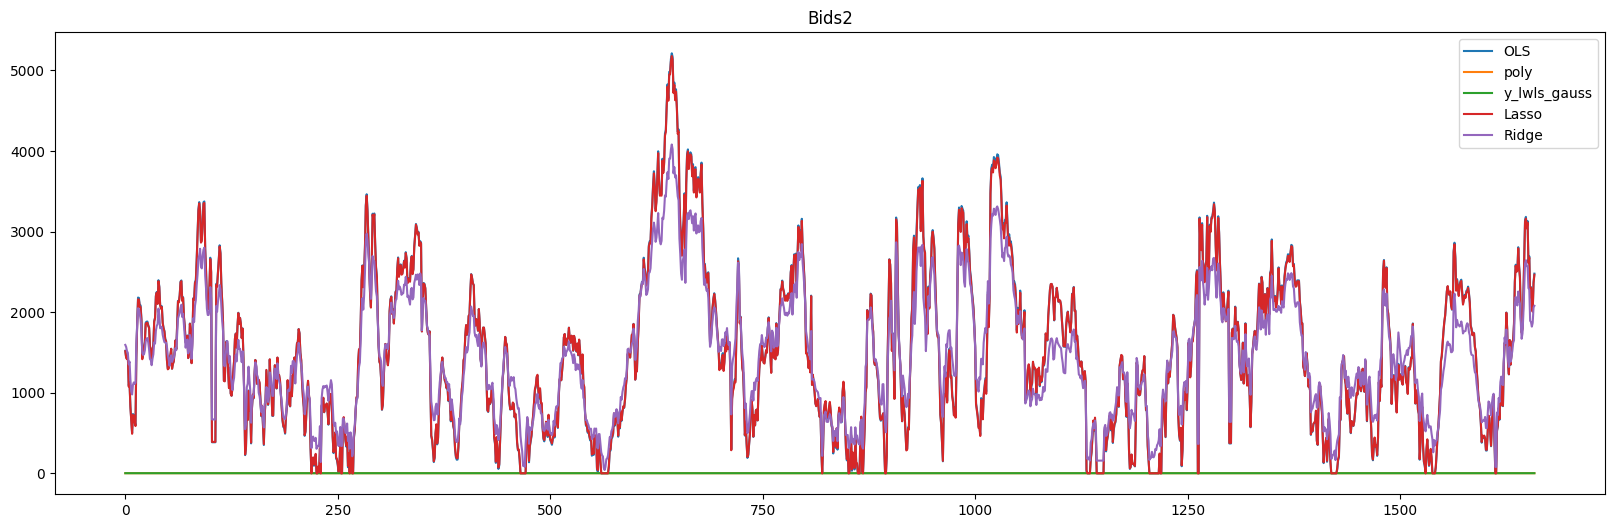

In [34]:
# Plot bids from original and modified model
plt.figure(figsize=(20, 6))
for model in model_names:
    plt.plot(bids[model], label=model)
plt.legend()
plt.title('Bids')
plt.show()

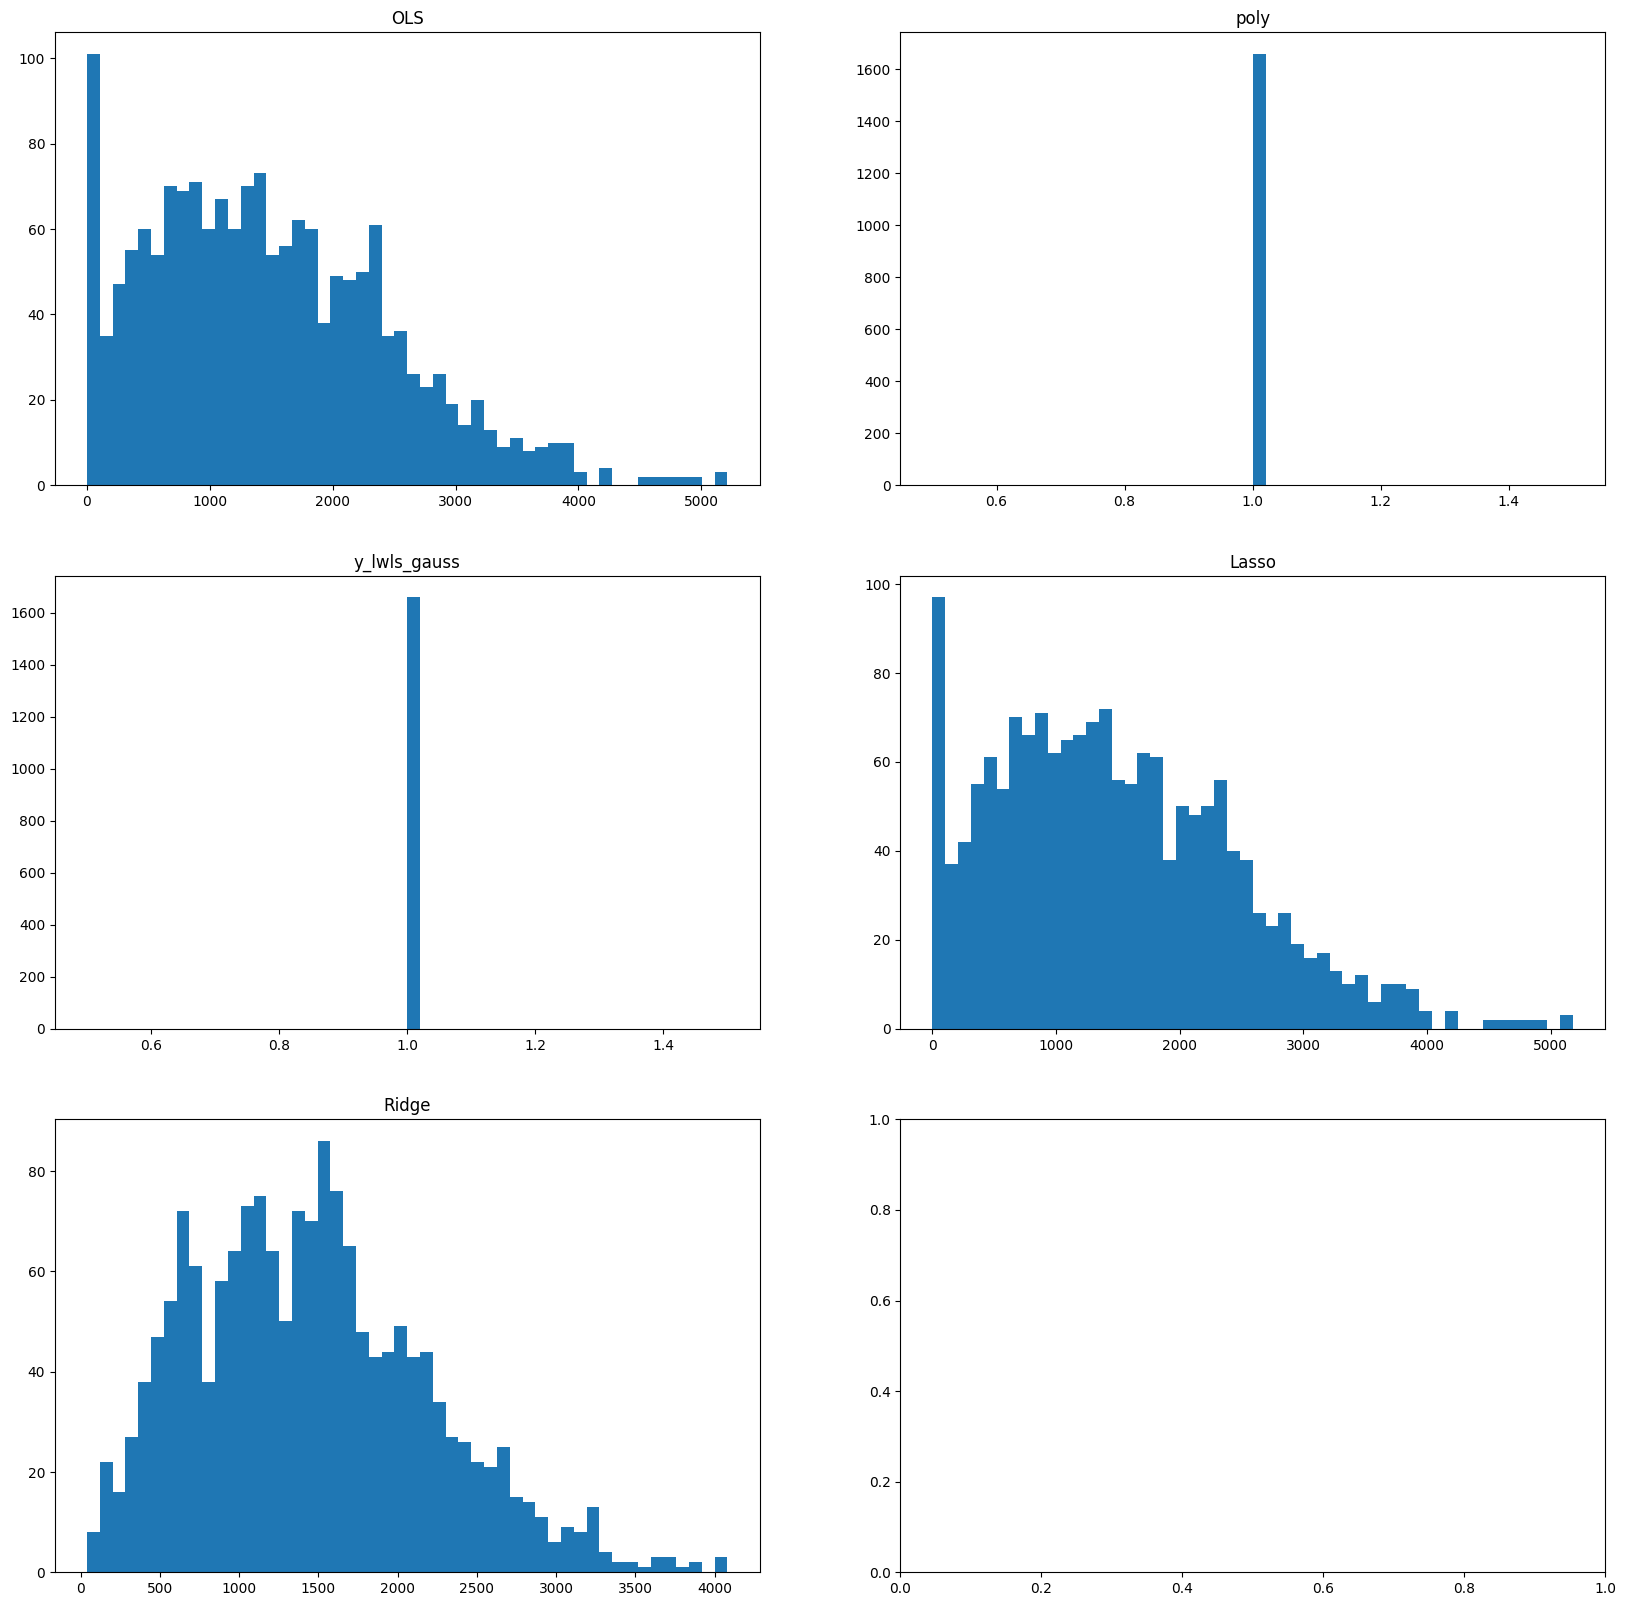

In [30]:
# Plot historgam of bids for each model in seperate subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i, model in enumerate(model_names):
    axs[i//2, i%2].hist(bids[model], bins=50)
    axs[i//2, i%2].set_title(model)
plt.show()


## Task 7 (optional): Suggestion for improvement

ValueError: x and y must be the same size

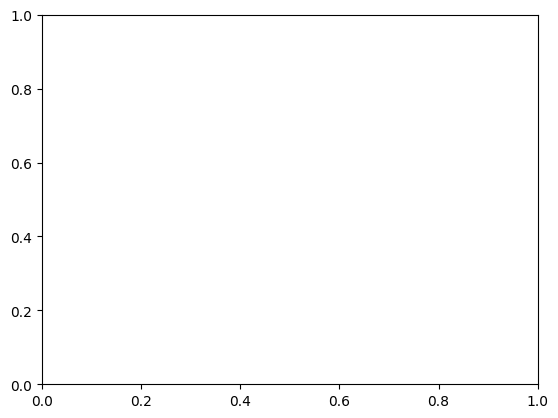

In [55]:
from sklearn.cluster import KMeans


# Implement clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(x).astype('int')

# Plot clusters
plt.scatter(x, y, c=clusters)
plt.show()

# Implement the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

## Task 8: Model 2